# Corridor Partitioning
### ~~A Bad~~ An Imperfect Simulated Annealing Solution

Suppose you have a length of road - call it a **"corridor"** - composed of $n$ road links.  You want to partition these links into segments such that all links in each segment are connected, and the total length of each segment is as close as possible to $d$.  Critically, the number of segments $s$ is not specified.  This problem arises from one step in a traffic congestion data processing pipeline, where a corridor must be partitioned into segments as close as possible to 200 metres.

For example, here are 6 links partitioned into 3 segments (A, B and C).

<a href="https://drive.google.com/uc?export=view&id=17sfN6rAbvre2D0ANrR-1G5GoknMUILB9"><img src="https://drive.google.com/uc?export=view&id=17sfN6rAbvre2D0ANrR-1G5GoknMUILB9" style="width: 500px; max-width: 100%; height: auto" title="Figure 1." /></a>

In segment A, only the rightmost link can be moved into B.  We cannot move the leftmost link to B because then B would not consist of connected segments.  No link in A can be moved into C.  (The leftmost link can be moved into a new segment if one were created to the left of A.)  Segment C only contains one link, because the link is large.  That link could be moved into B, but this would likely inflate the total length of B to well beyond $d$.

<a href="https://drive.google.com/uc?export=view&id=1pW-e90dCPMnWbZrzMTdiabZdXwPTbaRt"><img src="https://drive.google.com/uc?export=view&id=1pW-e90dCPMnWbZrzMTdiabZdXwPTbaRt" style="width: 500px; max-width: 100%; height: auto" title="Figure 1." /></a>

We can think of different partitions of links as different "states".  Moving links from one partition to another is a transition from one state to another.  The set of all states can be turned into a graph by making each state a node and connecting a node to any others it can transition into by moving a single link.  Unfortunately, depending on how we define a move (below) this graph could be directed (even if it isn't acyclic).

To find an optimal solution we must search the state space by walking the graph, which unfortunately cannot easily be mapped to the space of continous or ordinal model parameters (because the state space itself isn't continuous or ordered).  Instead, we can look at [stochastic optimization](http://www.wisdom.weizmann.ac.il/~ethanf/MCMC/stochastic%20optimization.pdf) techniques that stochastically explore the state space with a bias for more optimal states.  A heuristic method capable of solving similar combinatorics optimization problems is simulated annealing:

![SegmentLocal](https://upload.wikimedia.org/wikipedia/commons/1/10/Travelling_salesman_problem_solved_with_simulated_annealing.gif "segment")

[Simulated annealing](https://en.wikipedia.org/wiki/Simulated_annealing) is a metahueristic (adapted from [Metropolis-Hastings](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm)) to approximate the global minimum loss of a system by traversing its state space in a sequence of "moves", or perturbations.  Each move is probabilistically accepted, with this probability dependent on whether the loss is smaller if the move is accepted.  In our system, the loss is some measure of the typical difference between segment length and $d$ (such as mean squared error).  Initially, there is some probability of accepting a move even if it increases the loss, but this probability is reduced to some minimum value over time.  This reduces the chances of being trapped in a local minimum close to the state at the start of annealing.  In simulated annealing the loss is called "energy" and probability of accepting larger loss values "temperature", since the inspiration for the algorithm comes from annealing in metallurgy, so we can also say that the temperature is decreased over time to force the system to its lowest energy.

We'll use [Simanneal](https://github.com/perrygeo/simanneal), a simple annealing package that offers more customizability than scipy's version (a more advanced algorithm can be found in [pycsa](https://github.com/structurely/csa)).

In [1]:
import numpy as np
import copy
import sklearn.metrics as metrics
from simanneal import Annealer

In [2]:
# We start by defining a simple container to 
class Link:
    """Link information."""
    
    def __init__(self, id, length):
        self._id = id
        self._length = length
    
    @property
    def id(self):
        return self._id
    
    @property
    def length(self):
        return self._length
    
    def __repr__(self):
        return "{0}: {1}".format(self._id, self._length)

In [3]:
def seg_total_length(part):
    return sum([l.length for l in part])

def greedy_partitioning(corridor, d):
    # Start by populating the first partition.
    partitions = []
    partitions.append([Link(0, corridor[0])])

    # Cycling through line segments...
    for i_, item in enumerate(corridor[1:]):
        # Since we're starting at corridor[1].
        i = i_ + 1
        # If partition's getting too large, start a new partition.
        if (seg_total_length(partitions[-1]) + item) > d:
            partitions.append([Link(i, item)])
        # Otherwise append to current partition.
        else:
            partitions[-1].append(Link(i, item))
    
    return partitions

In [4]:
# For reproducibility, use hardcoded values.
corridor = [92., 57., 510., 22., 108., 363., 72., 110., 226., 193.]
partitions = greedy_partitioning(corridor, 200.)

In [5]:
partitions

[[0: 92.0, 1: 57.0],
 [2: 510.0],
 [3: 22.0, 4: 108.0],
 [5: 363.0],
 [6: 72.0, 7: 110.0],
 [8: 226.0],
 [9: 193.0]]

By default, simanneal uses deepcopy.  Let's ensure this can successfully reproduce our partitioning.

In [6]:
part2 = copy.deepcopy(partitions)

In [7]:
part2[0][0]._id = -999
part2[1][0]._length = 3333333

In [8]:
part2

[[-999: 92.0, 1: 57.0],
 [2: 3333333],
 [3: 22.0, 4: 108.0],
 [5: 363.0],
 [6: 72.0, 7: 110.0],
 [8: 226.0],
 [9: 193.0]]

In [9]:
partitions

[[0: 92.0, 1: 57.0],
 [2: 510.0],
 [3: 22.0, 4: 108.0],
 [5: 363.0],
 [6: 72.0, 7: 110.0],
 [8: 226.0],
 [9: 193.0]]

Cool, copying works.  Now let's try formulating a movement.

In [10]:
def move_segment(partitions, idx, ismoveleft):
    # If the left boundary segment of the first partition is to be moved
    # create a new partition.  If there's only one element in the first
    # partition, do nothing, since it's equivalent to creating a new
    # partition and deleting the old one.
    if idx == 0 and ismoveleft:
        if len(partitions[0]) > 1:
            mpart = partitions[0][0]
            del partitions[0][0]
            partitions.insert(0, [mpart, ])
    # Same logic as before, except for right boundary segment of the
    # final partition.
    elif idx == (len(partitions) - 1) and not ismoveleft:
        if len(partitions[-1]) > 1:
            mpart = partitions[-1][-1]
            del partitions[-1][-1]
            partitions.append([mpart, ])
    # Otherwise we're dealing with moving an element in the middle.
    else:
        # If we're moving the left boundary segment leftward.
        if ismoveleft:
            mpart = partitions[idx][0]
            del partitions[idx][0]
            partitions[idx - 1].append(mpart)
            if not len(partitions[idx]):
                del partitions[idx]
        # Otherwise move the right boundary segment rightward.
        else:
            mpart = partitions[idx][-1]
            del partitions[idx][-1]
            partitions[idx + 1].insert(0, mpart)
            if not len(partitions[idx]):
                del partitions[idx]

In [11]:
part2 = copy.deepcopy(partitions)
part2

[[0: 92.0, 1: 57.0],
 [2: 510.0],
 [3: 22.0, 4: 108.0],
 [5: 363.0],
 [6: 72.0, 7: 110.0],
 [8: 226.0],
 [9: 193.0]]

In [12]:
move_segment(part2, 1, False)
part2

[[0: 92.0, 1: 57.0],
 [2: 510.0, 3: 22.0, 4: 108.0],
 [5: 363.0],
 [6: 72.0, 7: 110.0],
 [8: 226.0],
 [9: 193.0]]

In [13]:
move_segment(part2, 1, True)
part2

[[0: 92.0, 1: 57.0, 2: 510.0],
 [3: 22.0, 4: 108.0],
 [5: 363.0],
 [6: 72.0, 7: 110.0],
 [8: 226.0],
 [9: 193.0]]

In [14]:
move_segment(part2, 0, True)
part2

[[0: 92.0],
 [1: 57.0, 2: 510.0],
 [3: 22.0, 4: 108.0],
 [5: 363.0],
 [6: 72.0, 7: 110.0],
 [8: 226.0],
 [9: 193.0]]

In [15]:
move_segment(part2, 1, True)
part2

[[0: 92.0, 1: 57.0],
 [2: 510.0],
 [3: 22.0, 4: 108.0],
 [5: 363.0],
 [6: 72.0, 7: 110.0],
 [8: 226.0],
 [9: 193.0]]

So that's our original state.  It's not completely inaccessible, but we can't jump back between two states in state space.

In [16]:
move_segment(part2, 6, False)
part2

[[0: 92.0, 1: 57.0],
 [2: 510.0],
 [3: 22.0, 4: 108.0],
 [5: 363.0],
 [6: 72.0, 7: 110.0],
 [8: 226.0],
 [9: 193.0]]

In [17]:
move_segment(part2, 5, False)
part2

[[0: 92.0, 1: 57.0],
 [2: 510.0],
 [3: 22.0, 4: 108.0],
 [5: 363.0],
 [6: 72.0, 7: 110.0],
 [8: 226.0, 9: 193.0]]

In [18]:
move_segment(part2, 4, True)
part2

[[0: 92.0, 1: 57.0],
 [2: 510.0],
 [3: 22.0, 4: 108.0],
 [5: 363.0, 6: 72.0],
 [7: 110.0],
 [8: 226.0, 9: 193.0]]

In [19]:
move_segment(part2, 4, True)
part2

[[0: 92.0, 1: 57.0],
 [2: 510.0],
 [3: 22.0, 4: 108.0],
 [5: 363.0, 6: 72.0, 7: 110.0],
 [8: 226.0, 9: 193.0]]

As mentioned in [Selecting the parameters](https://en.wikipedia.org/wiki/Simulated_annealing#Selecting_the_parameters), we must consider:

- The feasibility of reaching the global minimum from the starting state.  If we consider the graph picture mentioned previously, this is equivalent to stating that the number of edges from the starting state node to the global minimum is traversible in the number of steps allotted to the annealling.
- The `move` function should be biased toward moves to new states with similar energies to current states.  This typically is beneficial since moves from low to high-energy states are much more common than moves from high to low-energy.
- The `move` function should also try to avoid deep potential wells, to prevent the algorithm from getting stuck in a local minimum.
- Whether restarting - periodically going back to the best solution seen thus far - is available (it isn't in Simanneal).

The first of these points is problematic for our move algorithm, since while technically we could use it to rearrange the corridor into any number of segments (including one segment with all links in it or $n$ segments, each with only one link), some states are super-convoluted to get to.  There's also a tendency to reduce the number of partitions, since moving every element out of a partition will eliminate it.  This is hopefully counterbalanced by the fact that reducing the number of partitions is energetically unfavourable, but then we run into the problem of getting trapped in local minima.

Let's write the annealer, adapting some of the functions from above.

In [20]:
class SegmentPartitionProblem(Annealer):
    """Attempt at solving the partitioning problem with simulated annealing."""

    def __init__(self, corridor, d=200., metric=metrics.mean_squared_error):
        self.d = d
        self.metric = metric
        
        if len(corridor) < 2:
            raise ValueError("corridor has too few links to optimize.")
        state = self.greedy_partitioning(corridor)
        # Feed initial state to the Annealer.
        super().__init__(state)

    @staticmethod
    def seg_total_length(part):
        return sum([l.length for l in part])
    
    def corridor_total_length(self):
        return np.array([self.seg_total_length(seg) for seg in self.state])

    def greedy_partitioning(self, corridor):
        """Greedy algorithm to partition corridor.

        Moving from left to right, add links to a segment until its length
        is greater than `d`, then create a new segment and continue.
        """
        # Start by populating the first segment.
        segments = []
        segments.append([Link(0, corridor[0])])

        # Cycling through links...
        for i_, item in enumerate(corridor[1:]):
            # Since we're starting at corridor[1].
            i = i_ + 1
            # If segment's getting too large, start a new one.
            if (self.seg_total_length(segments[-1]) + item) > self.d:
                segments.append([Link(i, item)])
            # Otherwise append to current segment.
            else:
                segments[-1].append(Link(i, item))

        return segments

    def move(self):
        """Randomly move a boundary link from one partition to another."""
        idx = np.random.randint(0, len(self.state))
        ismoveleft = bool(np.random.randint(0, 2))
        self.move_link(idx, ismoveleft)

    def move_link(self, idx, ismoveleft):
        """Move a boundary link from one partition to another.

        Boundary links are the first or last links within a partition.
        It is only possible to move the left boundary link (the first link in the list)
        leftward, or the right boundary link (last link in the list) rightward.

        It's possible to move the first link left or the last link right;
        new segments are made in those cases.  If a segment is completely
        empty after the move, it is deleted.

        Parameters
        ----------
        idx : int
            Index of segment for move.
        ismoveleft : bool
            If True, move left boundary link; otherwise move right boundary link.
        """
        # If the left boundary link of the first segment is to be moved, create a new segment.
        # If there's only one link in the first segment, do nothing, since it's
        # equivalent to creating a new segment and deleting the old one.
        if idx == 0 and ismoveleft:
            if len(self.state[0]) > 1:
                mpart = self.state[0][0]
                del self.state[0][0]
                self.state.insert(0, [mpart, ])
        # Same logic as before, except for right boundary link of the
        # final segment.
        elif idx == (len(self.state) - 1) and not ismoveleft:
            if len(self.state[-1]) > 1:
                mpart = self.state[-1][-1]
                del self.state[-1][-1]
                self.state.append([mpart, ])
        # Otherwise we're dealing with moving a link in the middle.
        else:
            # If we're moving the left boundary link.
            if ismoveleft:
                mpart = self.state[idx][0]
                del self.state[idx][0]
                self.state[idx - 1].append(mpart)
                if not len(self.state[idx]):
                    del self.state[idx]
            # Otherwise move the right boundary link.
            else:
                mpart = self.state[idx][-1]
                del self.state[idx][-1]
                self.state[idx + 1].insert(0, mpart)
                if not len(self.state[idx]):
                    del self.state[idx]

    def energy(self):
        """Calculate error between each segment's total length and its expected
        total length."""
        total_lengths = self.corridor_total_length()
        expected_lengths = self.d * np.ones_like(total_lengths)
        return self.metric(expected_lengths, total_lengths)

Run a test with the example corridor.

In [21]:
solver = SegmentPartitionProblem(corridor)

In [22]:
# Double check the copy strategy.
solver.copy_strategy

'deepcopy'

In [23]:
# Check initial state.
solver.state

[[0: 92.0, 1: 57.0],
 [2: 510.0],
 [3: 22.0, 4: 108.0],
 [5: 363.0],
 [6: 72.0, 7: 110.0],
 [8: 226.0],
 [9: 193.0]]

In [24]:
# Check initial energy.
solver.energy()

18745.571428571428

In [25]:
auto_schedule = solver.auto(minutes=1)

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   220.00000      18745.57     5.85%     0.00%     0:00:22    -1:59:535

In [26]:
solver.set_schedule(auto_schedule)

In [27]:
results = solver.anneal()

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   220.00000      18745.57     6.95%     0.00%     0:01:02     0:00:005

In [28]:
results

([[0: 92.0, 1: 57.0],
  [2: 510.0],
  [3: 22.0, 4: 108.0],
  [5: 363.0],
  [6: 72.0, 7: 110.0],
  [8: 226.0],
  [9: 193.0]],
 18745.571428571428)

So the initial state is actually the best state!

Create a random data generator to test what happens if we have many, small segments.

In [29]:
def get_corridor(n, mean=100., stdev=300.):
    """Get a corridor with randomized segment lengths.
    
    Length is determined by drawing samples from a normal
    distribution, then taking the sample magnitudes.  This
    weights lengths slightly towards very small lengths.
    
    Parameters
    ----------
    n : int
        Number of corridor elements.
    mean : float
        Normal distribution mean.
    stdev : float
        Normal distribution standard deviation.
    """
    return list(np.round(np.abs(
        np.random.normal(loc=mean, scale=stdev, size=n))))

In [30]:
np.random.seed(1337)
corridor = get_corridor(30, mean=50., stdev=100.)

In [31]:
solver = SegmentPartitionProblem(corridor)

In [32]:
solver.state

[[0: 20.0, 1: 1.0, 2: 18.0, 3: 126.0],
 [4: 71.0],
 [5: 151.0, 6: 6.0],
 [7: 84.0],
 [8: 205.0],
 [9: 87.0],
 [10: 193.0],
 [11: 22.0, 12: 6.0, 13: 169.0],
 [14: 220.0],
 [15: 119.0, 16: 20.0],
 [17: 108.0],
 [18: 148.0],
 [19: 72.0, 20: 83.0],
 [21: 50.0, 22: 81.0, 23: 12.0],
 [24: 177.0],
 [25: 62.0, 26: 65.0],
 [27: 225.0],
 [28: 14.0, 29: 51.0]]

In [33]:
solver.corridor_total_length()

array([165.,  71., 157.,  84., 205.,  87., 193., 197., 220., 139., 108.,
       148., 155., 143., 177., 127., 225.,  65.])

In [34]:
import seaborn as sns
sns.distplot(solver.corridor_total_length(), bins=10).set_xlabel("Segment Length");

In [35]:
solver.set_schedule(solver.auto(minutes=1))
results = solver.anneal()

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     5.80000       6302.80     0.00%     0.00%     0:00:49    -1:59:389 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     5.80000       2910.18     0.00%     0.00%     0:01:00     0:00:009

In [36]:
solver.corridor_total_length()

array([236., 241., 205., 280., 197., 220., 247., 220., 214., 189., 127.,
       290.])

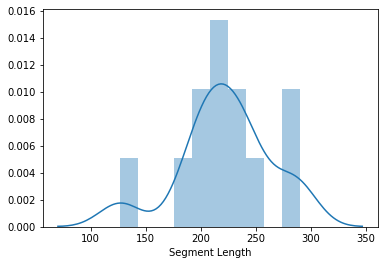

In [37]:
sns.distplot(solver.corridor_total_length(), bins=10).set_xlabel("Segment Length");

That suggests it's working!  Let's try some corridors from the traffic congestion project.

In [38]:
# Example corridors from traffic congestion project.
example_corridors = [[108.035663002834,  36.3493269138192,  55.8650320708702,  32.9769664202237,  196.851304920907,  59.8964704499386,  23.2182847680913,  85.807914857144,  151.092331004459,  39.0338833347077,  34.3229688917364,  121.139708134581,  27.2670739837142,  102.024441126267,  71.4888566159677,  57.6358233860716,  87.5483145225065,  151.867588464023,  51.8762479950161,  73.4483910936352,  88.1723110274047,  57.8684519571337,  80.2976375037638,  240.034193702877,  52.3916873566642,  63.3454377959634,  33.0425408742748,  65.7500892676688,  27.5643515725109,  28.4240525731706,  46.3967679118245,  22.9415533853597,  28.6271412345714,  33.5588041309022,  31.6722399471476,  31.6721941288426,  23.4590819274533,  51.8736895587082,  43.142586232185,  58.7233623854007,  58.3882063359139,  79.9535022904625,  41.7723430477161,  24.3113052233191,  41.7723046516112,  36.2950232015771,  20.7246707096798,  14.7275094616399,  36.2949033238534,  48.2846535862521,  75.6740110577666,  50.5026339802251,  40.4020229235464,  28.9321218492241,  18.8316841447558,  71.2200097161077,  62.4883973721617,  33.040637191983,  61.971832288805,  71.2192485290569,  18.8314066483498,  185.939685477312,  39.8916924182219,  98.1063999272967,  58.2148417789417,  22.4393112284188,  18.3245026117024,  48.6200222173686,  27.0510218592012,  22.939736003768,  216.407781286629,  41.76940490581,  18.8307014294711,  34.4091258120472,  53.2387569413552,  72.9284714470612,  66.0777756029017,  37.1492035045096,  72.4234396457456,  138.499670334431,  104.091349976908,  53.2374250901825,  51.2502331649752,  255.784426261236,  31.1620411153908,  27.0494583651457,  56.341547909864,  55.4693507104563,  138.856792658418,  36.2903445378504,  55.4687817524838,  233.970712773963,  25.6073765927039,  42.9846773433756], 
[43.3322960535908, 15.2317694334973, 37.553145931869, 66.4576887456021, 31.5188262787689, 89.83206266963, 27.8562284910165, 23.3749212582751, 38.6063587814294, 90.8904016282247, 31.518711582903, 212.4866941023, 199.617718628264, 49.92824706696, 25.7373724987402, 30.7385197676356, 21.5624654042709, 35.7397522965612, 19.2003211418065, 36.7778948219413, 45.957581125287, 18.6502714094554, 16.2887453711461, 38.104659500872, 28.100793469749, 62.2370937502756, 22.9262168607108, 63.4118368660728, 58.6940299378466, 27.8558774637043, 38.6057882716121, 23.3745649418426, 58.5628687124186, 43.0829799063322, 75.904822557057, 27.8557990505273, 23.1367540349806, 17.3525621021675, 24.4329458977031, 20.778661995072, 82.7462344236764, 71.1801913169134, 19.7117831583793, 17.3525223839492, 54.6489907989186, 55.9501909356492, 59.1352473751381, 19.7117410896125, 75.4229468816477, 32.5770766851726, 100.09237303507, 64.0940957526684, 27.8555734070257, 58.071470593449, 45.2073092936049, 50.9913055269466, 68.343442327036, 133.975268112742, 31.0124344552198, 66.4629121107177, 7.09108418064443, 161.072881254452, 105.820564356922, 92.3252109084544, 34.937988523104, 48.631622077719, 38.3598700210854, 46.7480018829608, 54.6507573655058, 102.705268729577, 23.6366941736929, 41.786033772474, 39.4228562002528, 161.82373053174, 34.9377514209139, 31.5173719396305, 40.9672535027125],
[40.9672535027125, 31.5173719396305, 34.9377514209139, 161.82373053174, 39.4228562002528, 41.786033772474, 23.6366941736929, 102.705268729577, 54.6507573655058, 46.7480018829608, 38.3598700210854, 48.631622077719, 34.937988523104, 92.3252109084544, 105.820564356922, 161.072881254452, 7.09108418064443, 66.4629121107177, 31.0124344552198, 133.975268112742, 68.343442327036, 50.9913055269466, 45.2073092936049, 58.071470593449, 27.8555734070257, 64.0940957526684, 100.09237303507, 32.5770766851726, 75.4229468816477, 19.7117410896125, 59.1352473751381, 55.9501909356492, 54.6489907989186, 17.3525223839492, 19.7117831583793, 71.1801913169134, 82.7462344236764, 20.778661995072, 24.4329458977031, 17.3525621021675, 23.1367540349806, 27.8557990505273, 75.904822557057, 43.0829799063322, 58.5628687124186, 23.3745649418426, 38.6057882716121, 27.8558774637043, 58.6940299378466, 63.4118368660728, 22.9262168607108, 62.2370937502756, 28.100793469749, 38.104659500872, 16.2887453711461, 18.6502714094554, 45.957581125287, 36.7778948219413, 19.2003211418065, 35.7397522965612, 21.5624654042709, 30.7385197676356, 25.7373724987402, 49.92824706696, 199.617718628264, 212.4866941023, 31.518711582903, 90.8904016282247, 38.6063587814294, 23.3749212582751, 27.8562284910165, 89.83206266963, 31.5188262787689, 66.4576887456021, 37.553145931869, 15.2317694334973, 43.3322960535908],
[43.9122884788382, 53.7983469512301, 21.6547192316875, 38.327960430402, 20.2552876703088, 42.7056488538901, 47.4945338514941, 41.6077649599573, 37.2293386146595, 32.578468614947, 26.965629877382, 39.2904538804517, 15.7401247488697, 20.4020958549128, 21.0664692150769, 59.3838425405733, 25.9025737090605, 44.7177358242737, 42.6366342289516, 94.7176938008645, 21.9135495272078, 52.4561355280815, 34.6745235441967, 17.8482123255172, 25.6660963378523, 35.7781885333039, 43.5142273165254, 35.6326972684601, 33.4162436223115, 33.4162427565233, 43.3946744192632, 54.4904921928303, 43.3948615472722, 35.0745680580758, 24.2044296947356, 23.3730087539598, 28.0978982756079, 52.2852105569614, 32.3451966823251, 48.6297892784661, 21.8489605617128, 24.2044789339881, 22.0707796700311, 13.9271115770084, 35.997869051853, 32.3452574413314, 44.4308186067617, 14.6433849813245, 11.2258652254868, 42.9786489825867, 44.0703966302936, 41.7403668594042, 38.4625752466884, 15.8839396959431, 99.2489136824961, 31.9967799146365, 20.2490559029512, 14.4760336924105, 30.2245280760726],
[30.2245280760726, 14.4760336924105, 20.2490559029512, 31.9967799146365, 99.2489136824961, 15.8839396959431, 38.4625752466884, 41.7403668594042, 44.0703966302936, 42.9786489825867, 11.2258652254868, 14.6433849813245, 44.4308186067617, 32.3452574413314, 35.997869051853, 13.9271115770084, 22.0707796700311, 24.2044789339881, 21.8489605617128, 48.6297892784661, 32.3451966823251, 52.2852105569614, 28.0978982756079, 23.3730087539598, 24.2044296947356, 35.0745680580758, 43.3948615472722, 54.4904921928303, 43.3946744192632, 33.4162427565233, 33.4162436223115, 35.6326972684601, 43.5142273165254, 35.7781885333039, 25.6660963378523, 17.8482123255172, 34.6745235441967, 52.4561355280815, 21.9135495272078, 94.7176938008645, 42.6366342289516, 44.7177358242737, 25.9025737090605, 59.3838425405733, 21.0664692150769, 20.4020958549128, 15.7401247488697, 39.2904538804517, 26.965629877382, 32.578468614947, 37.2293386146595, 41.6077649599573, 47.4945338514941, 42.7056488538901, 20.2552876703088, 38.327960430402, 21.6547192316875, 53.7983469512301, 43.9122884788382],
[51.7348359340052, 40.6459624986873, 31.6135227168797, 38.4616593430485, 36.1297318523954, 75.832807965218, 43.1357278255351, 24.7705756106359, 28.1911477669846, 97.0276197402394, 37.2233925967333, 21.4888013472453, 50.7749874222646, 48.7387352856405, 40.7971081771935, 22.5810463391401, 18.0648358932458, 21.4887852352262, 24.7705510374963, 13.5486242172265, 52.9611305335156, 53.1016793762553, 12.4570214530365, 41.8867569238042, 11.3691737768238, 32.8554968049279, 62.1340065617777, 32.8554836976003, 114.144014730195, 31.6134122087689, 82.3850290700663, 44.0692699662509, 42.8339760380519, 47.4934861478668, 36.1295848513365, 73.4982265977486, 162.583041568809, 34.8979491659277, 47.4934245298045, 64.4660933692024, 99.357652859174, 35.0369048881424, 6.71423930184276, 23.6749581193898, 18.0647590644371, 30.5207882703614],
[30.5207882703614, 18.0647590644371, 23.6749581193898, 6.71423930184276, 35.0369048881424, 99.357652859174, 64.4660933692024, 47.4934245298045, 34.8979491659277, 162.583041568809, 73.4982265977486, 36.1295848513365, 47.4934861478668, 42.8339760380519, 44.0692699662509, 82.3850290700663, 31.6134122087689, 114.144014730195, 32.8554836976003, 62.1340065617777, 32.8554968049279, 11.3691737768238, 41.8867569238042, 12.4570214530365, 53.1016793762553, 52.9611305335156, 13.5486242172265, 24.7705510374963, 21.4887852352262, 18.0648358932458, 22.5810463391401, 40.7971081771935, 48.7387352856405, 50.7749874222646, 21.4888013472453, 37.2233925967333, 97.0276197402394, 28.1911477669846, 24.7705756106359, 43.1357278255351, 75.832807965218, 36.1297318523954, 38.4616593430485, 31.6135227168797, 40.6459624986873, 51.7348359340052],
[34.7857880749479, 21.3532071460444, 21.4893063154619, 50.6374361912783, 55.0293583060298, 50.5157580897135, 95.7947582655433, 10.1274925323022, 11.2257264021074, 109.083622887493, 15.7399129339999, 42.8338994382592, 74.3114391102625, 20.2549973237217, 21.3525714861332, 98.9543461449536, 50.6375111039725, 27.0971639313463, 42.7051597033947, 36.1295605734664, 32.5781141405074, 77.6020149235851, 102.372081788096, 49.5410280796146, 49.5410340301293, 30.3825380552624, 31.4798748865856, 33.8020791274275, 29.2862382907462, 77.6020806751652, 15.7399426055273, 81.0209566934965, 30.3825585716893, 43.9293844171047, 29.286259003755, 20.2550435492187, 55.1530267624081, 20.2550469959979, 24.7705491966206, 35.9948629982111, 33.8021234023955, 65.4144692298576, 32.7072392898428, 23.6750504881048, 41.8917354971051, 69.138414016805, 39.0267525584743],
[39.0267525584743, 69.138414016805, 41.8917354971051, 23.6750504881048, 32.7072392898428, 65.4144692298576, 33.8021234023955, 35.9948629982111, 24.7705491966206, 20.2550469959979, 55.1530267624081, 20.2550435492187, 29.286259003755, 43.9293844171047, 30.3825585716893, 81.0209566934965, 15.7399426055273, 77.6020806751652, 29.2862382907462, 33.8020791274275, 31.4798748865856, 30.3825380552624, 49.5410340301293, 49.5410280796146, 102.372081788096, 77.6020149235851, 32.5781141405074, 36.1295605734664, 42.7051597033947, 27.0971639313463, 50.6375111039725, 98.9543461449536, 21.3525714861332, 20.2549973237217, 74.3114391102625, 42.8338994382592, 15.7399129339999, 109.083622887493, 11.2257264021074, 10.1274925323022, 95.7947582655433, 50.5157580897135, 55.0293583060298, 50.6374361912783, 21.4893063154619, 21.3532071460444, 34.7857880749479]]

In [39]:
mse_greedy = []
mse_anneal = []
segment_distribution_greedy = []
segment_distribution_anneal = []

for corridor in example_corridors:
    solver = SegmentPartitionProblem(corridor)
    segment_distribution_greedy += list(solver.corridor_total_length())
    mse_greedy.append(solver.energy())
    solver.set_schedule(solver.auto(minutes=1))
    solver.anneal();
    segment_distribution_anneal += list(solver.corridor_total_length())
    mse_anneal.append(solver.energy())

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     7.30000       6938.27     0.00%     0.00%     0:01:46    -1:59:05 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     7.30000       5964.82     0.34%     0.17%     0:00:56     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.07300       2963.67     0.00%     0.00%     0:01:38    -1:59:06 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.07300       3329.41     0.00%     0.00%     0:00:58     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.50000       3841.81     0.00%     0.00%     0:01:20    -1:59:19 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.50000       3344.03     1.79%     0.90%     0:00:58     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.26000        236.24     0.00%     0.00%     0:01:01    -1:59:31 Temperature 

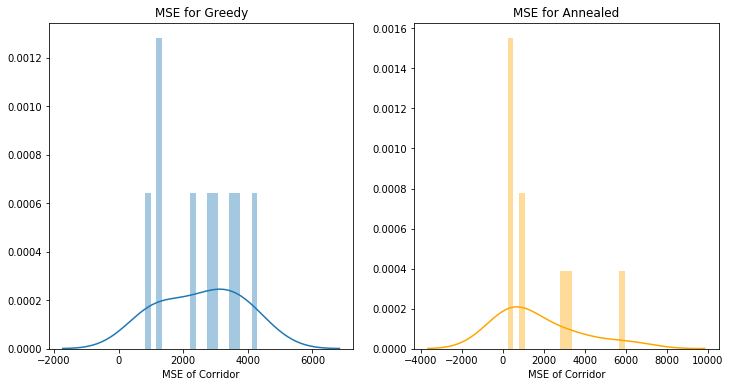

In [43]:
import matplotlib.pyplot as plt
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6))
sns.distplot(mse_greedy, ax=ax1, bins=20).set_title('MSE for Greedy');
ax1.set_xlabel("MSE of Corridor");
sns.distplot(mse_anneal, ax=ax2, bins=20, color='orange').set_title('MSE for Annealed');
ax2.set_xlabel("MSE of Corridor");

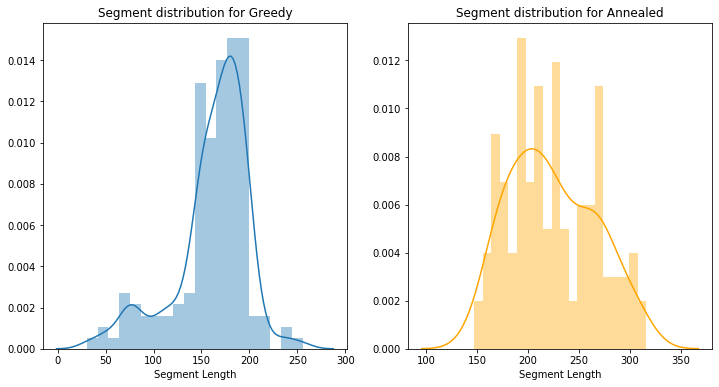

In [44]:
import matplotlib.pyplot as plt
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6))
sns.distplot(segment_distribution_greedy, ax=ax1, bins=20).set_title('Segment distribution for Greedy');
ax1.set_xlabel("Segment Length");
sns.distplot(segment_distribution_anneal, ax=ax2, bins=20, color='orange').set_title('Segment distribution for Annealed');
ax2.set_xlabel("Segment Length");

These results are promising!  For small numbers of links, using `itertools.combinations` is preferable, but for intractibly large corridors, simulated annealing is a viable solution.